The following is a simple simulation for a two level system with a drive that either has a constant amplitude or comes in two short pulses.

The Hamiltonian is 
$$
H = \omega_0 \frac{\sigma_z}{2} + A(t) \frac{\Omega}{2} \cos(\omega t) \sigma_x
$$

where $A(t)$ is the envelope. The two-pulse envelope has the parameter $\tau$, which is the 1/e duration of each pulse. You can think of the drive strength $\Omega$ as the rate of Rabi oscillations.

We look at the expectation value $<x>$ - this means we don't have to go into the interaction frame to cancel fast oscillations, and it represents many real meausurement devices.

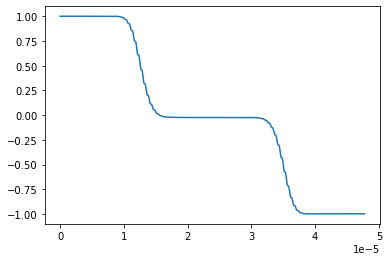

In [157]:
from qutip import *
import numpy as np
import matplotlib.pyplot as plt 

σx = Qobj(np.array([[0,1],[1,0]]))
σy = Qobj(np.array([[0,-1j],[1j,0]]))
σz = Qobj(np.array([[1,0],[0,-1]]))

π = np.pi

ω = 1e6 * 2*π

ω0 = 1e6 * 2*π
Ω = 0.12e6 * 2*π

dt = 1/ω0 * 0.3

t = np.linspace(0, dt*1000, 1000+1)

ψ = basis(2,0)

H0 = - ω0/2 * σz

def dual_pulse(t):
    
    dt = t[1]-t[0]
    
    t1 = t[len(t)//4]
    t2 = t[3*len(t)//4]
    τ = dt*50
    
    envelope = np.exp(-(t-t1)**2/τ**2)
    envelope += np.exp(-(t-t2)**2/τ**2)
    return envelope

def constant(t):
    return t*0 + 1

#select one of the two excitation pulse envelopes
envelope = dual_pulse(t) # If tuned to two pi/2 pulses, this becomes the Ramsey pulse sequence.
# envelope = constant(t) # Just a constant drive

H = [H0, [Ω/2*σx, np.cos(ω*t)*envelope]]

result = mesolve(H, ψ, t, e_ops = [σz])

plt.plot(t,result.expect[0])

Now imagine that this simulation represents the behavior of spin dipoles in a magnetic field. In this case, the natural (Larmor) frequency $\omega_0$ is dependent on a static magnetic field $B_0$ via the gyromagnetic relation $\omega_0 = B_0 \gamma$. This is all terminology from the field of magnetic resonance.

Imagine that we want to do spectroscopy on the sample. For example, if we knew $B_0$ and found $\omega_0$, we could obtain $\gamma$, which would indicate which spin species is present. Let us see the effect of running the same simulation several times, with a variation in the drive frequency $\Delta \omega$.

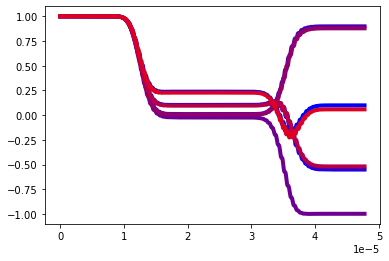

In [158]:
Δω = 50e3 * 2*π

N = 7 # number of sims

ω = 1e6 * 2*π + np.linspace(-Δω, Δω, N)

envelope = dual_pulse(t) # If tuned to two pi/2 pulses, this becomes the Ramsey pulse sequence.
# envelope = constant(t) # Just a constant drive

traces = []

for i in range(0,N):
    
    H0 = - ω0/2 * σz
    H = [H0, [Ω/2*σx, np.cos(ω[i]*t)*envelope]]
    result = mesolve(H, ψ, t, e_ops = [σz, σx])
    traces.append(result.expect[0])

for i in range(0,N):

    plt.plot(t,traces[i],color=(i/(N),0,1-(i/(N))),linewidth=4)

In the plot, red and blue are off-resonance, and purple is on-resonance. Try switching between dual pulse and constant envelope. If the two pulse envelope is close to two $\pi/2$ pulses (i.e., does the first pulse change $<z>$ from 1 to roughly 0), then you'll find that the final value of the trajectory is much more sensitive to detuning than in the constant envelope case. In other words, all else being equal, the Ramsey pulse sequence is more sensitive to detuning than a "regular" spectroscopy measurement.

This does break down if the detuning gets very big - the final state probability is still periodic in detuning, to first order.

We can understand why if we look at the $<y>$ expectation value, which should go from 0 to 1 from a $\pi/2$ pulse starting at ground. In order to demodulate the fast rotations, we will actually use the quantity

$$
f(t) = \Re \left[ (<x> + i <y>) \exp(i \omega t) \right]
$$

which is equivalent to going into the interaction frame.

See the Obsidian page on "Pauli Matrices and IQ Space" for more.

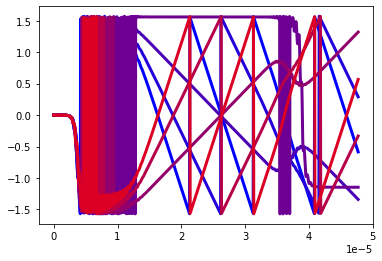

In [171]:
traces = []

for i in range(0,N):
    
    H0 = - ω0/2 * σz
    H = [H0, [Ω/2*σx, np.cos(ω[i]*t)*envelope]]
    result = mesolve(H, ψ, t, e_ops = [σx,σy])
    traces.append((result.expect[0]+1j*result.expect[1])*np.exp(1j*ω[i]*t))

for i in range(0,N):

    plt.plot(t,np.unwrap(np.arctan(np.imag(traces[i])/(np.real(traces[i])+1e-6))),color=(i/(N),0,1-(i/(N))),linewidth=3)

Finally, it would be helpful to see the same comparison, but with a variation in the enevelope time (pulse time gap or length of constant drive) instead of a variable detuning. In the dual pulse case, this is on

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50


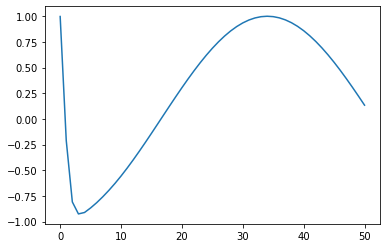

In [173]:
ω = 1.01e6 * 2*π

ω0 = 1e6 * 2*π
Ω = 0.12e6 * 2*π

dt = 1/ω0 * 0.3

steps = np.linspace(1,3000,51)

Pf = steps*0 + 1 # final value

for i in range(0,len(steps)):
    
    print(i)
    
    t = np.linspace(0, dt*steps[i], int(steps[i]+1))

    ψ = basis(2,0)

    H0 = - ω0/2 * σz

    t1 = t[len(t)//4]
    t2 = t[3*len(t)//4]
    τ = dt*50

    #select one of the two excitation pulse envelopes
    envelope = dual_pulse(t) # If tuned to two pi/2 pulses, this becomes the Ramsey pulse sequence.
#     envelope = constant(t) # Just a constant drive

    H = [H0, [Ω/2*σx, np.cos(ω*t)*envelope]]

    result = mesolve(H, ψ, t, e_ops = [σz])

    Pf[i] = result.expect[0][-1]
    
plt.plot(Pf)